# Progetto abilità informatiche e Telematiche: a.a 2022/23
## Matteo la Torre 


In [173]:
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [174]:
TEST_COVARIANCE=True
PLOTS=True

#### Parametri dei test

In [175]:
test = 3

if test==1:
    sigs = [0.02, 0.02, 0.02]
    ls = [25, 50, 75]
elif test==2:
    sigs = [0.02, 0.01, 0.005]
    ls = [50, 50, 50]
else:
    sigs = [0.02, 0.01, 0.005]
    ls = [5, 5, 5]

### 1. Singolo multipolo

1.1 Apertura dati

In [176]:
Nbins=200
Nmeasures=100 
measures=[]

for i in np.arange(Nmeasures)+1:
    fname = f'data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    file = fits.open(fname)
    table = file[1].data.copy()
    measures.append(table['XI0'])
    if i==1:
        scale = table['SCALE']
    del table
    file.close()

measures=np.asarray(measures).transpose()

1.2 CALCOLO DI MEDIA E COVARIANZA 

In [177]:
mean_xi = np.mean(measures,axis=1)
cov_xi = np.cov(measures)

1.3 CALCOLO DI COVARIANZA TRAMITE DEFINIZIONE

In [178]:
if TEST_COVARIANCE:

    AVE = np.zeros((Nbins,),dtype=float)
    COV = np.zeros((Nbins,Nbins),dtype=float)

    for i in range(Nmeasures):
        AVE += measures[:,i]
    AVE /= Nmeasures

    for i in range(Nbins):
        for j in range(Nbins):
            COV[i,j] = (np.sum(measures[i]*measures[j]) - AVE[i]*AVE[j]*Nmeasures) / (Nmeasures-1)

    print('Largest deviation between my calculation and numpy: {}'.format(np.max(np.abs(COV-cov_xi))))

Largest deviation between my calculation and numpy: 4.13469172094727e-14


1.4 CALCOLO DELLA COVARIANZA TEORICA

Calcoliamo la covarianza teorica come

$$C^{th}= \sigma_i\sigma_j \sqrt{\frac{2h_ih_j}{h_i^2+h_j^2}} exp(-\frac{x_1-x_2}{h_i^2+h_j^2})

In [179]:
def covf(x1, x2, sig, l):
    return sig**2.*np.exp(-(x1 - x2)**2./(2.*l**2.))


cov_th = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th[i,j] = covf(scale[i],scale[j],sigs[0],ls[0])

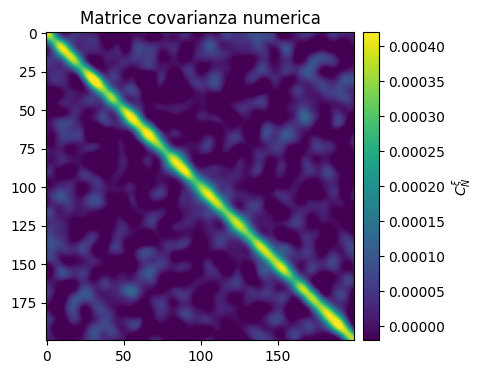

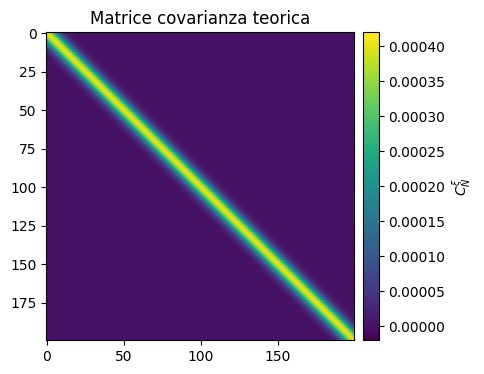

In [189]:
cmin = -np.max(cov_th)*0.05
cmax =  np.max(cov_th)*1.05

fig = plt.figure(figsize=(6,4))
plt.title('Matrice covarianza numerica')
plt.imshow(cov_xi, vmin=cmin, vmax=cmax)
cbar = plt.colorbar(orientation="vertical", pad=0.02)
cbar.set_label(r'$ C^{\xi}_{N}$')
plt.show()


fig = plt.figure(figsize=(6,4))
plt.title('Matrice covarianza teorica')
plt.imshow(cov_th, vmin=cmin, vmax=cmax)
cbar = plt.colorbar(orientation="vertical", pad=0.02)
cbar.set_label(r'$ C^{\xi}_{N}$')
plt.show()


1.5 CALCOLO DEI RESIDUI

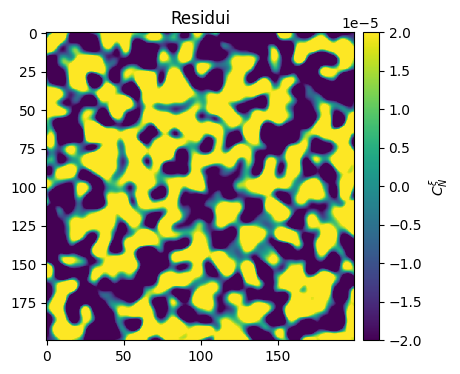

In [190]:
Res = cov_th-cov_xi
fig = plt.figure(figsize=(6,4))
plt.title('Residui')
plt.imshow(Res, vmin=cmin, vmax=-cmin)
cbar = plt.colorbar(orientation="vertical", pad=0.02)
cbar.set_label(r'$ C^{\xi}_{N}$')
plt.show()

1.6 CALCOLO DEI RESIDUI NORMALIZZATI TRAMITE MATRICE DI CORRELAZIONE

La matrice dei residui è definita come
$$Res_{ij} = (C^{th}_{ij}-C_{ij})\sqrt{\frac{N_{misure}-1}{(1+R_{ij})C_{ii}C_{jj}}}$$


con matrice di correlazione

$$ R_{ij} = \frac{C_{ij}^{th}}{\sqrt{C_{ii}^{th}C_{jj}^{th}}}



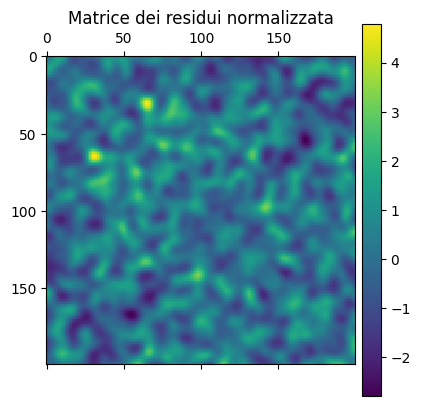

In [182]:
R=np.zeros((Nbins,Nbins),dtype=float) #Matrice di correlazione

for i in range(Nbins):
    for j in range(Nbins):
        R[i][j]=COV[i][j]/(COV[i][i]*COV[j][j])**0.5


Res_norm=np.zeros((Nbins,Nbins),dtype=float) #Matrice dei residui normalizzati

for i in range(Nbins):
    for j in range(Nbins):
        Res_norm[i][j]=(cov_th[i][j]-COV[i][j])*((Nmeasures-1)/((1.+R[i][j])*cov_th[i][i]*cov_th[j][j]))**0.5 #gaussiana con media 0 e deviazione standard 1


plt.matshow(Res_norm)
plt.title('Matrice dei residui normalizzata')
plt.colorbar(orientation="vertical", pad=0.02)
plt.show()

### 2. Tre multipoli

2.1 Apertura dati 

In [183]:
measures_1 = []
measures_2 = []
measures_3 = []

for i in np.arange(Nmeasures)+1:
    fname = f'data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    
    file=fits.open(fname)
    table=file[1].data.copy()
    measures_1.append(table['XI0'])
    measures_2.append(table['XI2'])
    measures_3.append(table['XI4'])
    if i==1:
        scale = table['SCALE']    
    del table
    file.close()

measures_1 = np.asarray(measures_1).transpose()
measures_2 = np.asarray(measures_2).transpose()
measures_3 = np.asarray(measures_3).transpose()

Measure = np.concatenate((measures_1, measures_2, measures_3))

2.2 CALCOLO DI MEDIA E COVARIANZA 

In [184]:
mean_xi_multipol = np.mean(Measure,axis=1)
cov_xi_multipol = np.cov(Measure)

2.3 CALCOLO DELLA COVARIANZA TEORICA

In [185]:
#COVARIANZA TEORICA PER DIVERSI MULTIPOLI

def covf1f2(x1, x2, sig1, l1, sig2, l2):
    return (np.sqrt(2.*l1*l2)*np.exp(-(np.sqrt((x1 - x2)**2.)**2./(l1**2. + l2**2.)))*sig1*sig2)/np.sqrt(l1**2. + l2**2.)

cov_th_multipol = np.zeros((Nbins*3,Nbins*3),dtype=float)

for k in range (0,3):
    for h in range (0,3):      
        for i in range(Nbins):
            for j in range(Nbins):
                cov_th_multipol[i+k*Nbins][j+h*Nbins] = covf1f2(scale[i],scale[j],sigs[k],ls[k],sigs[h],ls[h])


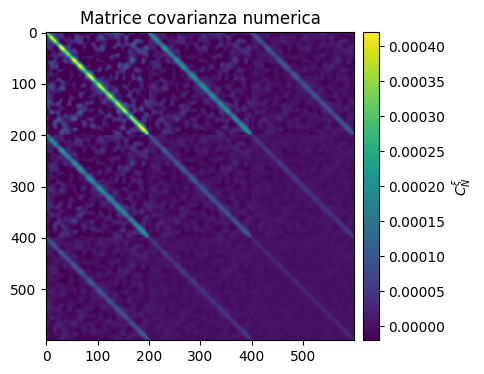

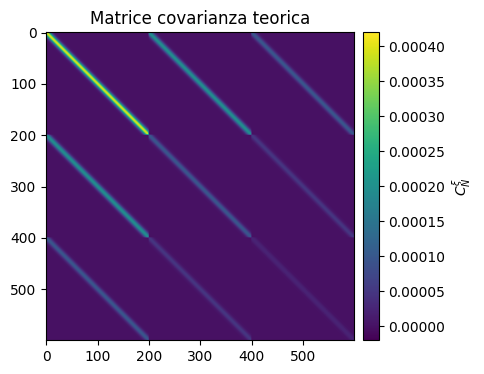

In [191]:
cmin = -np.max(cov_th_multipol)*0.05
cmax =  np.max(cov_th_multipol)*1.05

fig = plt.figure(figsize=(6,4))
plt.title('Matrice covarianza numerica')
plt.imshow(cov_xi_multipol, vmin=cmin, vmax=cmax)
cbar = plt.colorbar(orientation="vertical", pad=0.02)
cbar.set_label(r'$ C^{\xi}_{N}$')
plt.show()


fig = plt.figure(figsize=(6,4))
plt.title('Matrice covarianza teorica')
plt.imshow(cov_th_multipol, vmin=cmin, vmax=cmax)
cbar = plt.colorbar(orientation="vertical", pad=0.02)
cbar.set_label(r'$ C^{\xi}_{N}$')
plt.show()


2.4 CALCOLO DEI RESIDUI

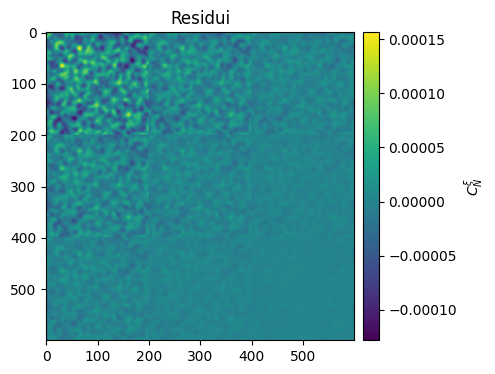

In [192]:
Res_multipol = cov_th_multipol-cov_xi_multipol
fig = plt.figure(figsize=(6,4))
plt.title('Residui')
plt.imshow(Res_multipol)
cbar = plt.colorbar(orientation="vertical", pad=0.02)
cbar.set_label(r'$ C^{\xi}_{N}$')
plt.show()

2.5 CALCOLO DEI RESIDUI NORMALIZZATI TRAMITE MATRICE DI CORRELAZIONE

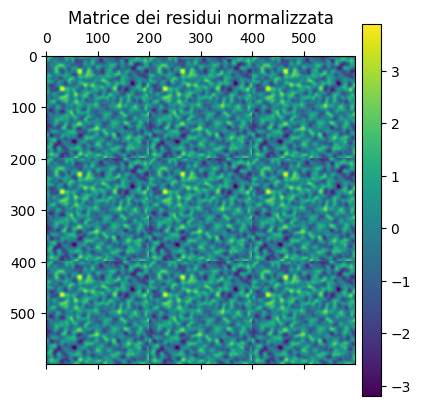

In [188]:
R_multipol=np.zeros((3*Nbins,3*Nbins),dtype=float) #Matrice di correlazione

for i in range(3*Nbins):
    for j in range(3*Nbins):
        R_multipol[i][j]=cov_th_multipol[i][j]/(cov_th_multipol[i][i]*cov_th_multipol[j][j])**0.5


Res_norm_multipol=np.zeros((3*Nbins,3*Nbins),dtype=float) 

for i in range(3*Nbins):
    for j in range(3*Nbins):
        Res_norm_multipol[i][j]=(cov_th_multipol[i][j]-cov_xi_multipol[i][j])*((Nmeasures-1)/((1.+R_multipol[i][j])*cov_th_multipol[i][i]*cov_th_multipol[j][j]))**0.5 

plt.matshow(Res_norm_multipol)
plt.title('Matrice dei residui normalizzata')
plt.colorbar(orientation="vertical", pad=0.02)
plt.show()